In [2]:
import numpy as np 
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Activation
import pandas as pd
import os
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")
import json

In [3]:
def create_xtest(data,n_predictions,n_next):
    """
    创建测试集
    """
    test_X = []
    for i in range(data.shape[0] - n_predictions - n_next + 1):
        a = data[(i + n_predictions - n_next ):(i +  (2 * n_predictions) - n_next),:]
        test_X.append(a)
    test_X = np.array(test_X,dtype='float64')
    return test_X

In [4]:
def Y_to_seq(Y):
    seq = []
    for i in range(Y.shape[0]):
        seq.append(Y[i,0])
    for i in range(1,Y.shape[1]):
        seq.append(Y[-1,i])
    return np.array(seq)

In [13]:
def create_dataset(data,n_predictions,n_next):
    '''
    对数据进行处理
    '''
    dim = data.shape[1]
    train_X, train_Y = [], []
    for i in range(data.shape[0]-n_predictions-n_next+1):
        a = data[i:(i+n_predictions),:]
        train_X.append(a)
        tempb = data[(i+n_predictions):(i+n_predictions+n_next),:]
        b = []
        for j in range(len(tempb)):
            for k in range(dim):
                b.append(tempb[j,k])
        train_Y.append(b)
    train_X = np.array(train_X,dtype='float64')
    train_Y = np.array(train_Y,dtype='float64')

    return train_X, train_Y
def trainModel(train_X, train_Y):
    '''
    trainX，trainY: 训练LSTM模型所需要的数据
    '''
    model = Sequential()
    model.add(LSTM(
        140,
        input_shape=(train_X.shape[1], train_X.shape[2]),
        return_sequences=True))
    model.add(Dropout(0.3))

    model.add(LSTM(
        140,
        return_sequences=False))
    model.add(Dropout(0.3))

    model.add(Dense(
        train_Y.shape[1]))
    model.add(Activation("relu"))

    model.compile(loss='mse', optimizer='adam')
    model.fit(train_X, train_Y, epochs=500, batch_size=64, verbose=1)

    return model
def reshape_y_hat(y_hat,dim):
    re_y = np.zeros(len(y_hat),dtype='float64')
    length =int(len(y_hat)/dim)
    re_y = re_y.reshape(length,dim)

    for curdim in range(dim):
        for i in range(length):
            re_y[i,curdim] = y_hat[i + curdim*length]

    return  re_y

In [6]:
with open('utilization.json','r') as f:
    dataset = json.load(f)
dataset = pd.DataFrame(dataset).T
data = dataset.values
data = data.astype('float32')

In [7]:
data.shape

(59, 4)

In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data.ravel().reshape(-1,1)).reshape(-1,1)

In [9]:
Xtrain,Ytrain = create_dataset(data,8,4)
Xtest = create_xtest(data,8,4)

In [14]:
model = trainModel(Xtrain,Ytrain)
model.save("./MultiSteup2.h5")

Epoch 1/500
225/225 [==============================] - 1s 6ms/sample - loss: 0.2309
Epoch 2/500
225/225 [==============================] - 0s 338us/sample - loss: 0.1269
Epoch 3/500
225/225 [==============================] - 0s 338us/sample - loss: 0.0805
Epoch 4/500
225/225 [==============================] - 0s 347us/sample - loss: 0.0621
Epoch 5/500
225/225 [==============================] - 0s 342us/sample - loss: 0.0683
Epoch 6/500
225/225 [==============================] - 0s 342us/sample - loss: 0.0604
Epoch 7/500
225/225 [==============================] - 0s 338us/sample - loss: 0.0582
Epoch 8/500
225/225 [==============================] - 0s 347us/sample - loss: 0.0576
Epoch 9/500
225/225 [==============================] - 0s 338us/sample - loss: 0.0562
Epoch 10/500
225/225 [==============================] - 0s 347us/sample - loss: 0.0565
Epoch 11/500
225/225 [==============================] - 0s 323us/sample - loss: 0.0556
Epoch 12/500
225/225 [==============================] 

In [15]:
y_hat = model.predict(Xtest)
Ytrain = scaler.inverse_transform(Ytrain)
Ypre = scaler.inverse_transform(y_hat)
data = scaler.inverse_transform(data)

In [16]:
Y_output = Y_to_seq(Ypre)

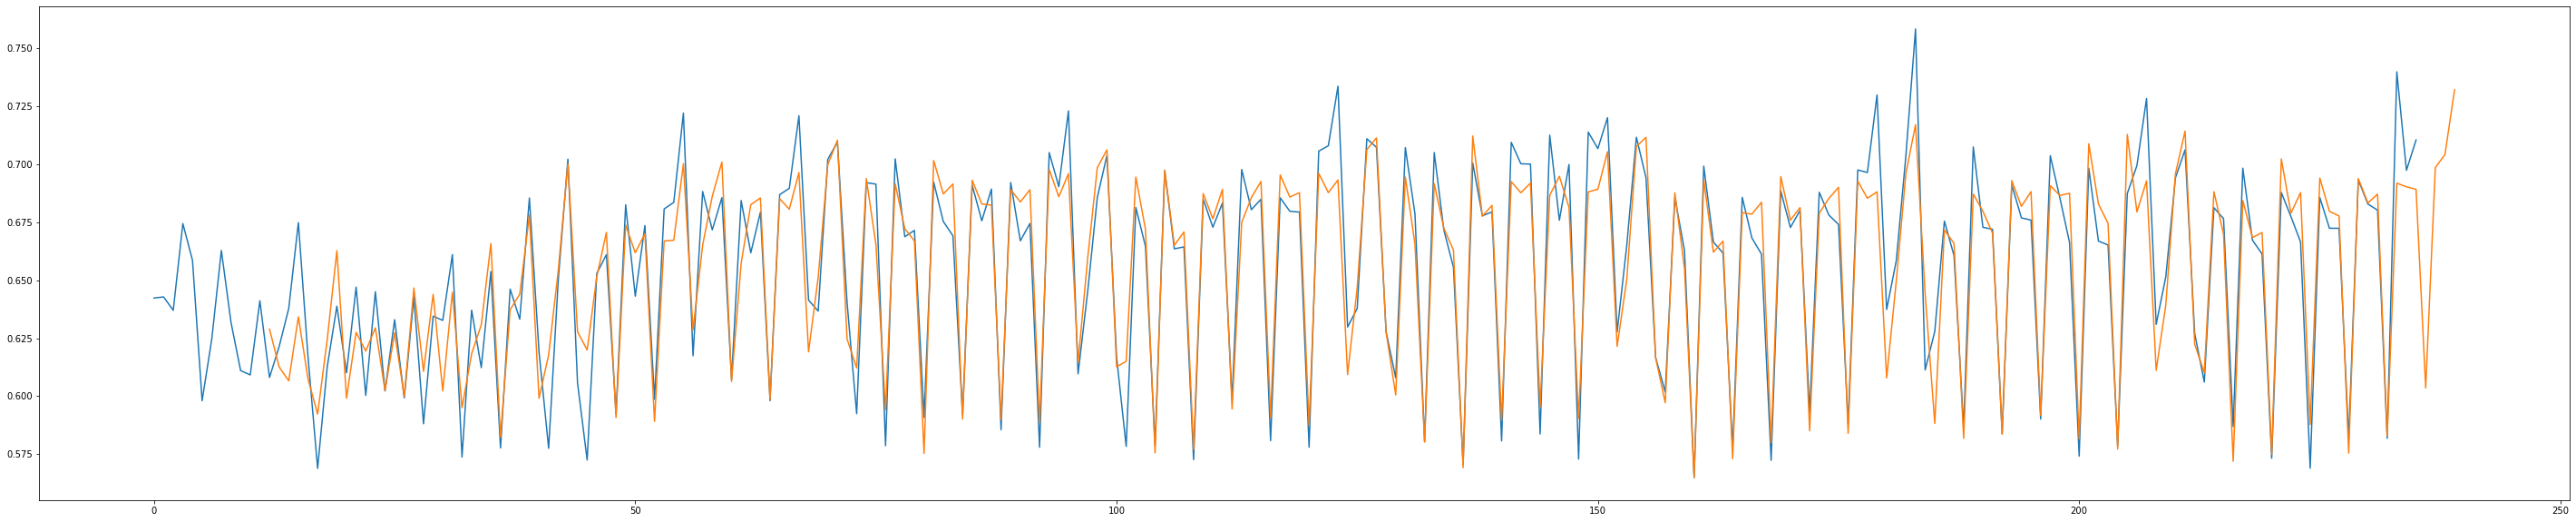

In [17]:
fig, ax = plt.subplots(figsize=(50,10))
x1 = range(data.shape[0])
x2 = range(12,Y_output.shape[0]+12)
plt.plot(x1,data)
plt.plot(x2,Y_output)
plt.show()

In [18]:
Y_output[-4:]
utilization = {
    'early_morning' : float(Y_output[-4:][0]),
    'morning' : float(Y_output[-4:][1]),
    'afternoon' : float(Y_output[-4:][2]),
    'night' : float(Y_output[-4:][3])
}

In [19]:
with open('utilization_predict.json','w') as f:
    json.dump(utilization,f)

In [20]:
utilization

{'early_morning': 0.6035876870155334,
 'morning': 0.6985844969749451,
 'afternoon': 0.7042079567909241,
 'night': 0.732139527797699}